In [7]:
! pip install -q kaggle

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!ls

kaggle.json  sample_data


In [8]:
!kaggle datasets download -d ruchirrathore/health

 76% 5.00M/6.54M [00:01<00:00, 4.47MB/s]
100% 6.54M/6.54M [00:01<00:00, 5.63MB/s]


In [9]:
!ls

health.zip  kaggle.json  sample_data


**Importing Libraries**

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
import tensorflow as tf

In [11]:
! unzip health

Archive:  health.zip
  inflating: healthcare/sample_sub.csv  
  inflating: healthcare/test_data.csv  
  inflating: healthcare/train_data.csv  
  inflating: healthcare/train_data_dictionary.csv  


In [12]:
data = pd.read_csv('healthcare/train_data.csv')

In [13]:
data

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.0,86499,23.0,Emergency,Moderate,3,41-50,4144.0,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.0,325,8.0,Urgent,Moderate,4,81-90,6699.0,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.0,125235,10.0,Emergency,Minor,3,71-80,4235.0,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.0,91081,8.0,Trauma,Minor,5,11-20,3761.0,11-20


In [14]:
train_data = pd.read_csv('healthcare/train_data.csv')
test_data = pd.read_csv('healthcare/test_data.csv')
sample_submission = pd.read_csv('healthcare/sample_sub.csv')
train_data.columns = train_data.columns.str.lower().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test_data.columns = test_data.columns.str.lower().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [16]:
print('Train Data Shape: ', train_data.shape)
print('Test Data Shape: ', test_data.shape)
train_data.head()

Train Data Shape:  (318438, 18)
Test Data Shape:  (137057, 17)


,case_id,hospital_code,hospital_type_code,city_code_hospital,hospital_region_code,available_extra_rooms_in_hospital,department,ward_type,ward_facility_code,bed_grade,patientid,city_code_patient,type_of_admission,severity_of_illness,visitors_with_patient,age,admission_deposit,stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


**Preprocessing**

Missing Values

In [17]:
data.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [18]:
def impute_missing_values(data, columns):
    for column in columns:
        data[column] = data[column].fillna(data[column].mean())

In [19]:
impute_columns = ['Bed Grade', 'City_Code_Patient']

impute_missing_values(data, impute_columns)

In [20]:
data.isnull().sum()

case_id                              0
Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
patientid                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
Stay                                 0
dtype: int64

In [21]:
data.dtypes

case_id                                int64
Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
patientid                              int64
City_Code_Patient                    float64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object

In [22]:
def get_categorical_uniques(data):
    categorical_columns = [column for column in data.dtypes.index if data.dtypes[column] == 'object']
    categorical_uniques = {column: data[column].unique() for column in categorical_columns}
    
    return categorical_uniques

In [23]:
get_categorical_uniques(data)

{'Age': array(['51-60', '71-80', '31-40', '41-50', '81-90', '61-70', '21-30',
        '11-20', '0-10', '91-100'], dtype=object),
 'Department': array(['radiotherapy', 'anesthesia', 'gynecology', 'TB & Chest disease',
        'surgery'], dtype=object),
 'Hospital_region_code': array(['Z', 'X', 'Y'], dtype=object),
 'Hospital_type_code': array(['c', 'e', 'b', 'a', 'f', 'd', 'g'], dtype=object),
 'Severity of Illness': array(['Extreme', 'Moderate', 'Minor'], dtype=object),
 'Stay': array(['0-10', '41-50', '31-40', '11-20', '51-60', '21-30', '71-80',
        'More than 100 Days', '81-90', '61-70', '91-100'], dtype=object),
 'Type of Admission': array(['Emergency', 'Trauma', 'Urgent'], dtype=object),
 'Ward_Facility_Code': array(['F', 'E', 'D', 'B', 'A', 'C'], dtype=object),
 'Ward_Type': array(['R', 'S', 'Q', 'P', 'T', 'U'], dtype=object)}

In [24]:
pd.get_dummies(data['Department'])

,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery
0,0,0,0,1,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
318433,0,0,0,1,0
318434,0,1,0,0,0
318435,0,0,1,0,0
318436,0,1,0,0,0


In [25]:
def onehot_encode(data, columns):
    for column in columns:
        dummies = pd.get_dummies(data[column])
        data = pd.concat([data, dummies], axis=1)
        data.drop(column, axis=1, inplace=True)
    return data

In [26]:
onehot_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code']


In [27]:
data = onehot_encode(data, onehot_columns)

In [28]:
data

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,a,b,c,d,e,f,g,X,Y,Z,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery,P,Q,R,S,T,U,A,B,C,D,E,F
0,1,8,3,3,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,2,2,5,2,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
2,3,10,1,2,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,4,26,2,2,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,5,26,2,2,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,6,3,4.0,86499,23.0,Emergency,Moderate,3,41-50,4144.0,11-20,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
318434,318435,24,1,2,4.0,325,8.0,Urgent,Moderate,4,81-90,6699.0,31-40,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
318435,318436,7,4,3,4.0,125235,10.0,Emergency,Minor,3,71-80,4235.0,11-20,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
318436,318437,11,2,3,3.0,91081,8.0,Trauma,Minor,5,11-20,3761.0,11-20,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [30]:
categorical_uniques = get_categorical_uniques(data)
get_categorical_uniques(data)

{'Age': array(['51-60', '71-80', '31-40', '41-50', '81-90', '61-70', '21-30',
        '11-20', '0-10', '91-100'], dtype=object),
 'Severity of Illness': array(['Extreme', 'Moderate', 'Minor'], dtype=object),
 'Stay': array(['0-10', '41-50', '31-40', '11-20', '51-60', '21-30', '71-80',
        'More than 100 Days', '81-90', '61-70', '91-100'], dtype=object),
 'Type of Admission': array(['Emergency', 'Trauma', 'Urgent'], dtype=object)}

In [31]:
for column in categorical_uniques:
    categorical_uniques[column] = sorted(categorical_uniques[column])
categorical_uniques

{'Age': ['0-10',
  '11-20',
  '21-30',
  '31-40',
  '41-50',
  '51-60',
  '61-70',
  '71-80',
  '81-90',
  '91-100'],
 'Severity of Illness': ['Extreme', 'Minor', 'Moderate'],
 'Stay': ['0-10',
  '11-20',
  '21-30',
  '31-40',
  '41-50',
  '51-60',
  '61-70',
  '71-80',
  '81-90',
  '91-100',
  'More than 100 Days'],
 'Type of Admission': ['Emergency', 'Trauma', 'Urgent']}

In [32]:
unique_list = categorical_uniques['Type of Admission']
unique_list.insert(0, unique_list.pop(unique_list.index('Urgent')))
unique_list.insert(0, unique_list.pop(unique_list.index('Trauma')))

unique_list = categorical_uniques['Severity of Illness']
unique_list.insert(0, unique_list.pop(unique_list.index('Moderate')))
unique_list.insert(0, unique_list.pop(unique_list.index('Minor')))

In [33]:
categorical_uniques

{'Age': ['0-10',
  '11-20',
  '21-30',
  '31-40',
  '41-50',
  '51-60',
  '61-70',
  '71-80',
  '81-90',
  '91-100'],
 'Severity of Illness': ['Minor', 'Moderate', 'Extreme'],
 'Stay': ['0-10',
  '11-20',
  '21-30',
  '31-40',
  '41-50',
  '51-60',
  '61-70',
  '71-80',
  '81-90',
  '91-100',
  'More than 100 Days'],
 'Type of Admission': ['Trauma', 'Urgent', 'Emergency']}

In [34]:
stay_mappings = {value: index for index, value in enumerate(categorical_uniques['Stay'])}
stay_mappings

{'0-10': 0,
 '11-20': 1,
 '21-30': 2,
 '31-40': 3,
 '41-50': 4,
 '51-60': 5,
 '61-70': 6,
 '71-80': 7,
 '81-90': 8,
 '91-100': 9,
 'More than 100 Days': 10}

In [35]:
def ordinal_encode(data, uniques):
    for column in uniques:
        data[column] = data[column].apply(lambda x: uniques[column].index(x))
data['Stay']

0          0-10
1         41-50
2         31-40
3         41-50
4         41-50
          ...  
318433    11-20
318434    31-40
318435    11-20
318436    11-20
318437     0-10
Name: Stay, Length: 318438, dtype: object

In [36]:
ordinal_encode(data, categorical_uniques)
data['Stay']

0         0
1         4
2         3
3         4
4         4
         ..
318433    1
318434    3
318435    1
318436    1
318437    0
Name: Stay, Length: 318438, dtype: int64

In [37]:
(data.dtypes == 'object').sum()

0

In [38]:
data

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,a,b,c,d,e,f,g,X,Y,Z,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery,P,Q,R,S,T,U,A,B,C,D,E,F
0,1,8,3,3,2.0,31397,7.0,2,2,2,5,4911.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,2,2,5,2,2.0,31397,7.0,0,2,2,5,5954.0,4,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
2,3,10,1,2,2.0,31397,7.0,0,2,2,5,4745.0,3,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,4,26,2,2,2.0,31397,7.0,0,2,2,5,7272.0,4,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,5,26,2,2,2.0,31397,7.0,0,2,2,5,5558.0,4,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,6,3,4.0,86499,23.0,2,1,3,4,4144.0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
318434,318435,24,1,2,4.0,325,8.0,1,1,4,8,6699.0,3,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
318435,318436,7,4,3,4.0,125235,10.0,2,0,3,7,4235.0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
318436,318437,11,2,3,3.0,91081,8.0,0,0,5,1,3761.0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [39]:
data.set_index('case_id', inplace=True)
y = data['Stay']
X = data.drop('Stay', axis=1)

In [40]:
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
X

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,a,b,c,d,e,f,g,X,Y,Z,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery,P,Q,R,S,T,U,A,B,C,D,E,F
case_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.195176,-0.571055,-0.169177,-0.716855,-0.904442,-0.053458,1.212557,1.646648,-0.727923,0.461600,0.027835,-0.905268,-0.525686,2.435861,-0.26155,-0.290425,-0.186494,-0.116679,-0.848727,-0.790317,2.020115,-0.176175,-0.320416,-1.902171,3.188572,-0.061529,-0.126891,-0.707202,1.220175,-0.568572,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,-0.440807,-0.458683,1.350633
2,-1.890124,0.073580,-1.025217,-0.716855,-0.904442,-0.053458,-0.974973,1.646648,-0.727923,0.461600,0.987556,-0.905268,-0.525686,2.435861,-0.26155,-0.290425,-0.186494,-0.116679,-0.848727,-0.790317,2.020115,-0.176175,-0.320416,-1.902171,3.188572,-0.061529,-0.126891,-0.707202,-0.819554,1.758792,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,-0.440807,-0.458683,1.350633
3,-0.963527,-1.215691,-1.025217,-0.716855,-0.904442,-0.053458,-0.974973,1.646648,-0.727923,0.461600,-0.124910,-0.905268,-0.525686,-0.410533,-0.26155,3.443224,-0.186494,-0.116679,1.178235,-0.790317,-0.495021,-0.176175,3.120939,-1.902171,-0.313620,-0.061529,-0.126891,-0.707202,-0.819554,1.758792,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,-0.440807,2.180153,-0.740394
4,0.889668,-0.893373,-1.025217,-0.716855,-0.904442,-0.053458,-0.974973,1.646648,-0.727923,0.461600,2.200319,-0.905268,1.902277,-0.410533,-0.26155,-0.290425,-0.186494,-0.116679,-0.848727,1.265315,-0.495021,-0.176175,-0.320416,-1.902171,3.188572,-0.061529,-0.126891,-0.707202,1.220175,-0.568572,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,2.268564,-0.458683,-0.740394
5,0.889668,-0.893373,-1.025217,-0.716855,-0.904442,-0.053458,-0.974973,1.646648,-0.727923,0.461600,0.623175,-0.905268,1.902277,-0.410533,-0.26155,-0.290425,-0.186494,-0.116679,-0.848727,1.265315,-0.495021,-0.176175,-0.320416,-1.902171,3.188572,-0.061529,-0.126891,-0.707202,-0.819554,1.758792,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,2.268564,-0.458683,-0.740394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318434,-1.426825,0.395897,-0.169177,1.574123,0.546379,3.342582,1.212557,0.138090,-0.161049,-0.067622,-0.677923,1.104645,-0.525686,-0.410533,-0.26155,-0.290425,-0.186494,-0.116679,1.178235,-0.790317,-0.495021,-0.176175,-0.320416,-1.902171,3.188572,-0.061529,-0.126891,1.414024,-0.819554,-0.568572,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,-0.440807,-0.458683,1.350633
318435,0.658018,-1.215691,-1.025217,1.574123,-1.722559,0.158795,0.118792,0.138090,0.405826,2.049268,1.673071,1.104645,-0.525686,-0.410533,-0.26155,-0.290425,-0.186494,-0.116679,1.178235,-0.790317,-0.495021,-0.176175,3.120939,-1.902171,-0.313620,-0.061529,-0.126891,1.414024,-0.819554,-0.568572,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,-0.440807,2.180153,-0.740394
318436,-1.311001,-0.248738,-0.169177,1.574123,1.566288,0.583300,1.212557,-1.370469,-0.161049,1.520045,-0.594189,1.104645,-0.525686,-0.410533,-0.26155,-0.290425,-0.186494,-0.116679,1.178235,-0.790317,-0.495021,-0.176175,-0.320416,0.525715,-0.313620,-0.061529,-0.126891,-0.707202,1.220175,-0.568572,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,-0.440807,-0.458683,1.350633


**Exploratory Data Analysis**

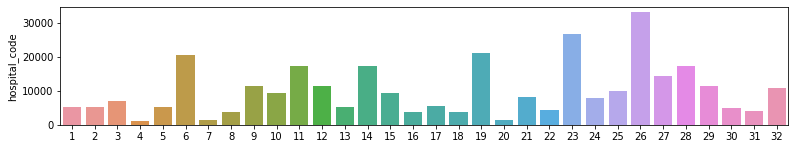

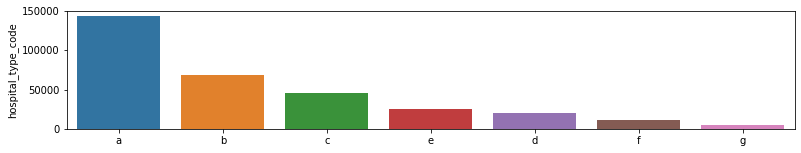

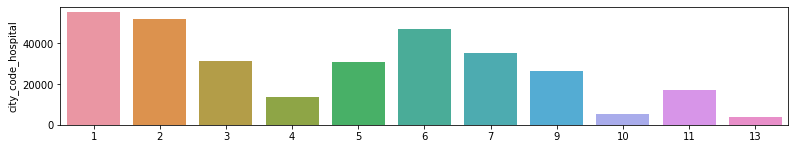

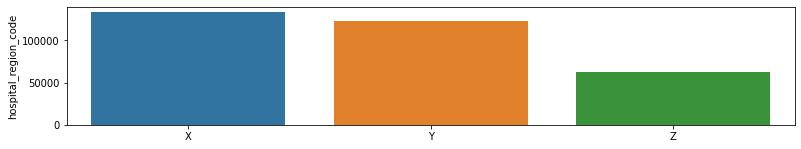

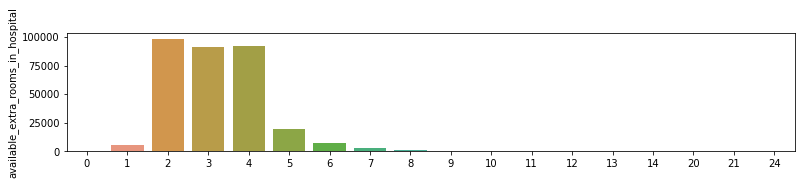

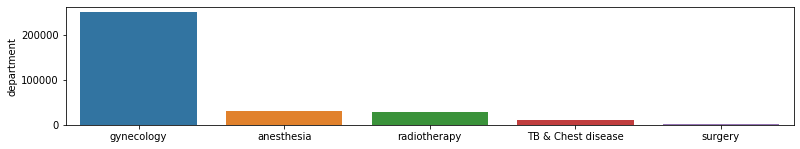

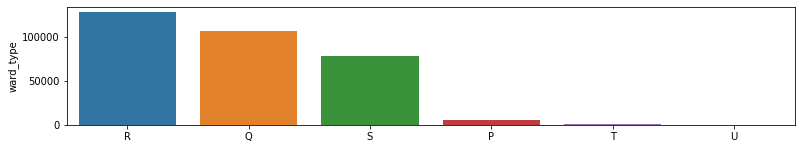

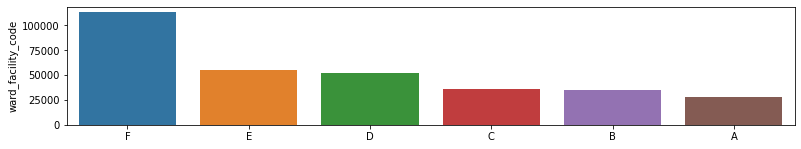

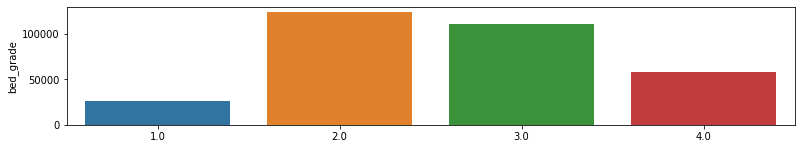

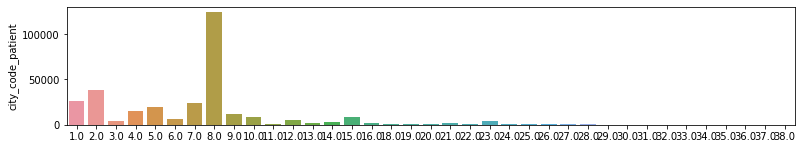

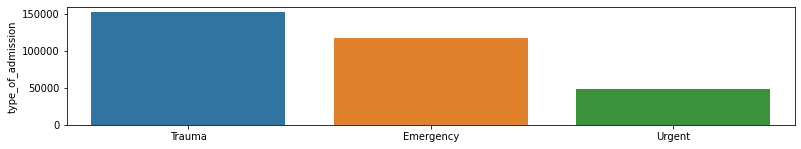

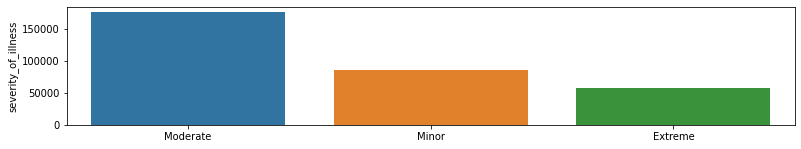

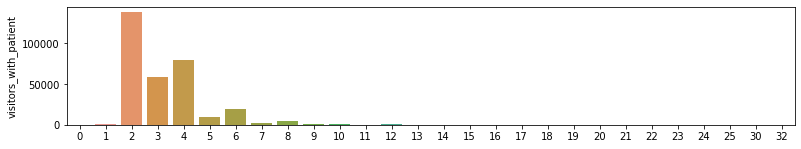

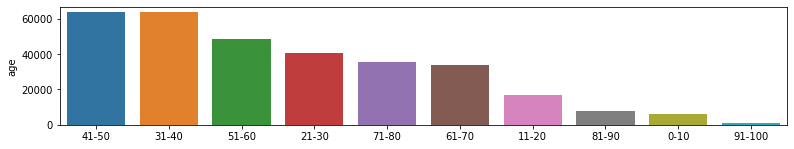

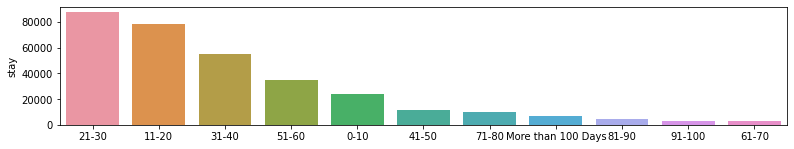

In [42]:
import seaborn as sns
i = 1
for column in train_data.columns[~(train_data.columns.isin(['case_id', 'patientid', 'admission_deposit']))].tolist():
    plt.figure(figsize = (60, 10))
    plt.subplot(4, 4, i)
    sns.barplot(x = train_data[column].value_counts().index, y = train_data[column].value_counts())
    i += 1
    plt.show()

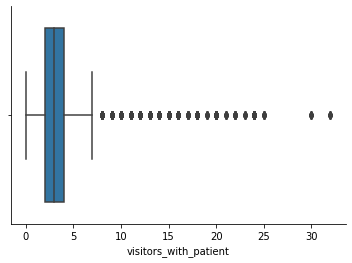

In [43]:
sns.boxplot(x = 'visitors_with_patient', data = train_data)
sns.despine()

**Training**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
inputs = tf.keras.Input(shape=(38,))
x = tf.keras.layers.Dense(16, activation='relu')(inputs)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

nn_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
nn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
batch_size = 32
epochs = 10

history = nn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/10
6369/6369 [==============================] - 9s 1ms/step - loss: 1.5364 - accuracy: 0.4096 - val_loss: 1.5335 - val_accuracy: 0.4117
Epoch 2/10
6369/6369 [==============================] - 9s 1ms/step - loss: 1.5358 - accuracy: 0.4108 - val_loss: 1.5308 - val_accuracy: 0.4127
Epoch 3/10
6369/6369 [==============================] - 9s 1ms/step - loss: 1.5349 - accuracy: 0.4106 - val_loss: 1.5312 - val_accuracy: 0.4129
Epoch 4/10
6369/6369 [==============================] - 9s 1ms/step - loss: 1.5343 - accuracy: 0.4109 - val_loss: 1.5311 - val_accuracy: 0.4128
Epoch 5/10
6369/6369 [==============================] - 9s 1ms/step - loss: 1.5337 - accuracy: 0.4112 - val_loss: 1.5311 - val_accuracy: 0.4119
Epoch 6/10
6369/6369 [==============================] - 9s 1ms/step - loss: 1.5331 - accuracy: 0.4119 - val_loss: 1.5294 - val_accuracy: 0.4122
Epoch 7/10
6369/6369 [==============================] - 9s 1ms/step - loss: 1.5328 - accuracy: 0.4119 - val_loss: 1.5292 - val_accuracy:

Results

In [ ]:
print(f"Logistic Regression Acc: {log_model.score(X_test, y_test)}")
print(f"     Neural Netowrk Acc: {nn_model.evaluate(X_test, y_test, verbose=0)[1]}")

Logistic Regression Acc: 0.3883777163672905
     Neural Netowrk Acc: 0.4128093123435974


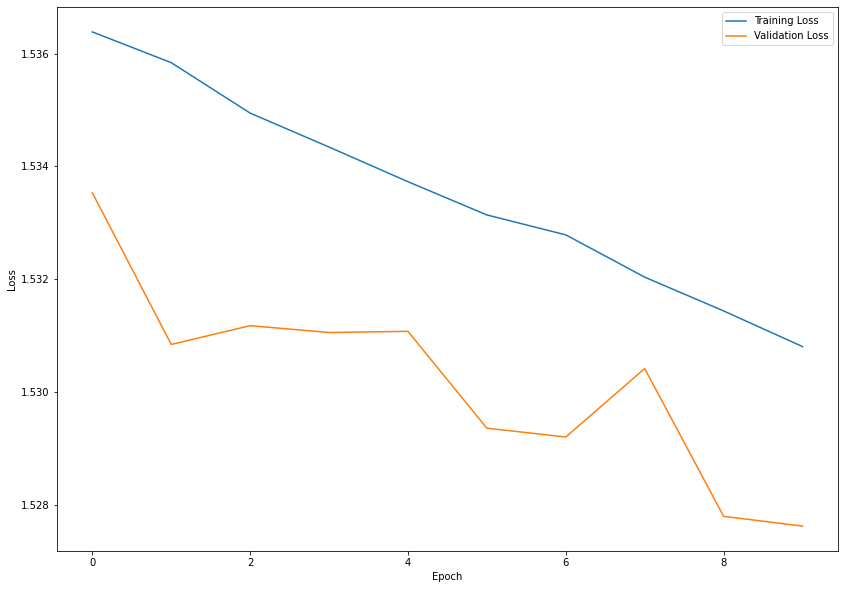

In [ ]:
plt.figure(figsize=(14, 10))

plt.plot(range(epochs), history.history['loss'], label="Training Loss")
plt.plot(range(epochs), history.history['val_loss'], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')

plt.show()

In [ ]:
np.argmin(history.history['val_loss']) + 1

10